<a href="https://colab.research.google.com/github/Gauthamsprasad/TensorFlow/blob/main/4_CNN_Multi_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi-class Image Classification

1. Become one with data
2. Preprocess the data
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different hyper-param and improve the model (beat the baseline)
7. Repeat until satisfied

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.image as mpimg

In [2]:
def view_random_image(target_dir, target_class):

  target_folder = target_dir +"/"+ target_class  # Selecting the folder of images

  random_image = random.sample(os.listdir(target_folder), 1)  # Selecting one image from the folder
  print(random_image)

  img = mpimg.imread(target_folder+"/"+random_image[0]) # random_image[0] reads the name of the file from the list
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image Shape: {img.shape}")
  return img


In [3]:
def plot_loss(history):
  train_loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  epoch = range(len(history.history["loss"]))

  plt.figure()
  plt.plot(epoch, train_loss, label = "training_loss")
  plt.plot(epoch, val_loss, label = "val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epoch, accuracy, label = "training_accuracy")
  plt.plot(epoch, val_accuracy, label = "val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

In [4]:
def load_and_prep_image(filename, img_shape = 224):

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor
  img = tf.image.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Scale the image into 0 - 1 range
  img = img/255.

  return img

In [5]:
def pred_and_plot(model, filename, class_names):
  img = load_and_prep_image(filename)
  pred = model.predict(tf.expand_dims(img, axis = 0))
  pred_class = class_names[int(tf.round(pred))]
  plt.imshow(img)
  plt.title(pred_class)
  plt.axis(False)

### 1. Import Data

In [6]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

#Unzip our data
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2025-12-16 15:04:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.207, 192.178.219.207, 74.125.134.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   183MB/s    in 2.7s    

2025-12-16 15:04:56 (183 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [7]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_all_data
There are 10 directories and 0 images in 10_food_classes_all_data/test
There are 0 directories and 250 images in 10_food_classes_all_data/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_all_data/test/fried_rice
There are 0 directories and 250 images in 10_food_classes_all_data/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_all_data/test/hamburger
There are 0 directories and 250 images in 10_food_classes_all_data/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_all_data/test/ramen
There are 0 directories and 250 images in 10_food_classes_all_data/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_all_data/test/steak
There are 0 directories and 250 images in 10_food_classes_all_data/test/pizza
There are 0 directories and 250 images in 10_food_classes_all_data/test/sushi
There are 10 directories and 0 images in 10_fo

In [8]:
# Setup the train and test directories

train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [9]:
# Lets get the class names
import pathlib
import numpy as np

data_dir = pathlib.Path(train_dir)
class_name = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_name)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


['2877759.jpg']
Image Shape: (512, 512, 3)


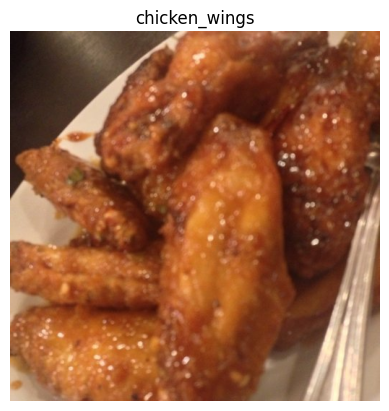

In [10]:
import random
img = view_random_image(train_dir,
                        random.choice(class_name))

### 2. Preprocess the data

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale
train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

# Load data in from directories and turn it into batches

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (224,224),
                                               batch_size = 32,
                                               class_mode = 'categorical')

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = (224,224),
                                              batch_size = 32,
                                              class_mode = 'categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [12]:
images , labels = next(train_data)

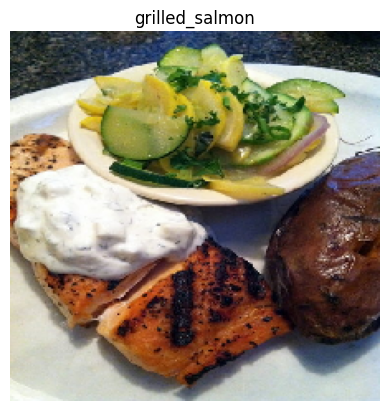

In [13]:
plt.imshow(images[3])
plt.title(class_name[np.argmax(labels[3])])
plt.axis(False);

### 3. Create a model (Baseline)

In [ ]:
from keras import activations
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

model_0 = Sequential([
    Conv2D(filters = 10,
           kernel_size = 3,
           activation = "relu",
           input_shape = (224,224,3)),
    MaxPool2D(),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation = "softmax")
])

model_0.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(),
    metrics = ["accuracy"]
)

model_0.fit(
    train_data,
    epochs = 5,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = int(0.25 * len(test_data)) # To reduce the validation process on a huge test data
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 141s 592ms/step - accuracy: 0.1973 - loss: 2.1927 - val_accuracy: 0.3618 - val_loss: 1.9169
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 142s 604ms/step - accuracy: 0.3711 - loss: 1.8399 - val_accuracy: 0.3849 - val_loss: 1.8233
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 201s 600ms/step - accuracy: 0.4413 - loss: 1.6407 - val_accuracy: 0.3816 - val_loss: 1.7850
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 140s 594ms/step - accuracy: 0.5143 - loss: 1.4469 - val_accuracy: 0.3717 - val_loss: 1.8793
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 140s 586ms/step - accuracy: 0.6085 - loss: 1.2095 - val_accuracy: 0.3849 - val_loss: 1.9879


In [ ]:
from keras import activations
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

model_1 = Sequential([
    Conv2D(filters = 10,
           kernel_size = 3,
           activation = "relu",
           input_shape = (224,224,3)),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),

    Conv2D(10, 3, activation = "relu"),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),

    Flatten(),
    Dense(10, activation = "softmax")
])

model_1.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(),
    metrics = ["accuracy"]
)

history_1 = model_1.fit(
    train_data,
    epochs = 5,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = int(0.25 * len(test_data)) # To reduce the validation process on a huge test data
)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.1915 - loss: 2.1901 - val_accuracy: 0.2977 - val_loss: 1.9773
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.3463 - loss: 1.8759 - val_accuracy: 0.3141 - val_loss: 1.8982
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.4025 - loss: 1.7363 - val_accuracy: 0.3355 - val_loss: 1.8957
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.5114 - loss: 1.4540 - val_accuracy: 0.2977 - val_loss: 2.0692
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.6752 - loss: 1.0316 - val_accuracy: 0.3339 - val_loss: 2.4038


In [14]:
plot_loss(history_1)

NameError: name 'history_1' is not defined

From the loss curve we can see that the val_loss is going upwards therefore our model got **Overfit**

Lets,
1. Simplyfy the complexity of the model
2. Reduce the no of conv layers

In [ ]:
model_2 = Sequential([
    Conv2D(filters = 10,
           kernel_size = 3,
           activation = "relu",
           input_shape = (224,224,3)),
    MaxPool2D(),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation = "softmax")
])

model_2.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(),
    metrics = ["accuracy"]
)

history_2 = model_2.fit(
    train_data,
    epochs = 5,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data)) # To reduce the validation process on a huge test data


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 159s 674ms/step - accuracy: 0.1823 - loss: 2.3171 - val_accuracy: 0.2932 - val_loss: 1.9806
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 176s 751ms/step - accuracy: 0.3713 - loss: 1.8178 - val_accuracy: 0.3040 - val_loss: 1.9492
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 162s 689ms/step - accuracy: 0.5010 - loss: 1.5176 - val_accuracy: 0.3244 - val_loss: 2.0312
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 212s 732ms/step - accuracy: 0.6401 - loss: 1.1326 - val_accuracy: 0.3004 - val_loss: 2.2245
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 143s 607ms/step - accuracy: 0.7779 - loss: 0.7534 - val_accuracy: 0.3128 - val_loss: 2.4744


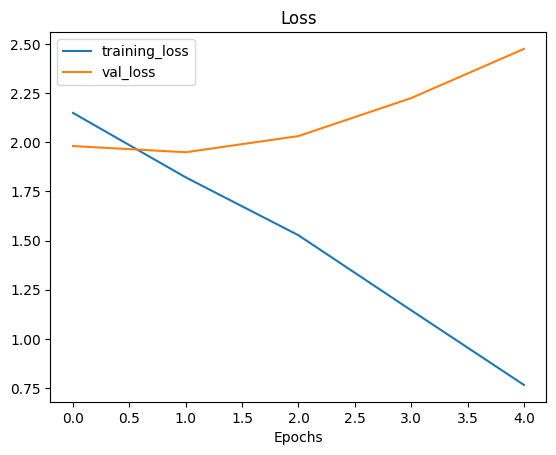

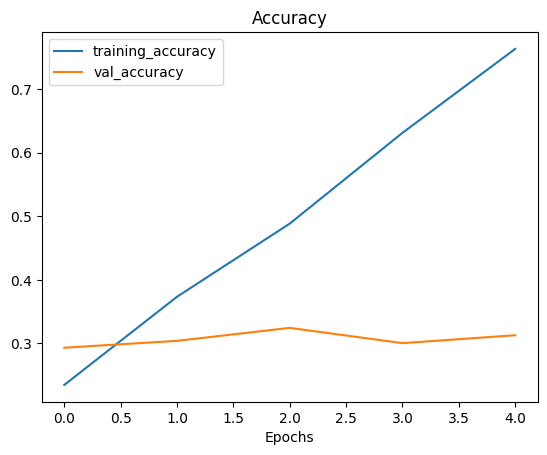

In [ ]:
plot_loss(history_2)

#### Data Augmentation to reduce Overfitting

In [15]:
train_datagen_aug = ImageDataGenerator(rescale = 1/255.,
                                       rotation_range = 0.2,
                                       width_shift_range = 0.2,
                                       height_shift_range = 0.2,
                                       zoom_range = 0.2,
                                       horizontal_flip = True
                                       )

train_data_aug = train_datagen_aug.flow_from_directory(train_dir,
                                                       target_size = (224,224),
                                                       batch_size = 32,
                                                       class_mode = 'categorical')

Found 7500 images belonging to 10 classes.


In [ ]:
images, labels = next(train_data_aug)

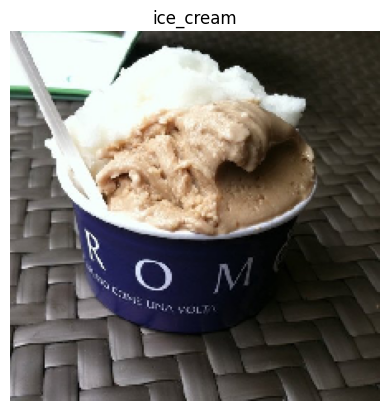

In [36]:
n = 5
plt.title(class_name[np.argmax(labels[n])])
plt.imshow(images[n])
plt.axis(False);

In [22]:
class_name

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [40]:
def pred_and_plot(model, filename, class_names):
  img = load_and_prep_image(filename)
  pred = model.predict(tf.expand_dims(img, axis = 0))

  if len(pred[0]) > 1:
    pred_class = class_names[np.argmax(pred[0])]
  else:
    pred_class = class_names[tf.round(pred[0])]

  plt.imshow(img)
  plt.title(pred_class)
  plt.axis(False)

Looks lik our model did'nr perform well on test data
it only achive 39% accuracy
